In [96]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl


In [97]:
def perfect_lens_coords(x1, y1, z1, vx1, vy1, vz1, z2, f, m_p, fourier_lens = 0.0):
    if np.abs(m_p) < 1e-10:
        z1 = -1e10
        m_p = z2 / z1
        temp_m_p = True

    vx_pp1 = 0.0 - x1
    vy_pp1 = 0.0 - y1
    vz_pp1 = z1
    v_mag = np.sqrt(vx_pp1**2 + vy_pp1**2 + vz_pp1**2)
    
    M1_p = vy_pp1 / v_mag
    L1_p = vx_pp1 / v_mag
    N1_p = np.sqrt(1 - L1_p ** 2 - M1_p ** 2)
    
    v1_mag = np.sqrt(vx1**2 + vy1**2 + vz1**2)
    
    L1 = vx1 / v1_mag
    M1 = vy1 / v1_mag
    N1 = np.sqrt(1 - L1 **2 - M1 ** 2)
    
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # if temp_m_p:
    #     L1 = L1_p
    #     M1 = M1_p
    
    if np.abs(m_p) <= 1.0:
        
        if fourier_lens:
            # Fourier lens uses sin of angle between principal ray direction and focal plane
            # which equates to using L1_p, M1_p as the direction vectors to find the point where
            # principal plane goes through back focal plane.
            direction_1p_x = L1_p
            direction_1p_y = M1_p
        else:
            # Paraxial lens uses tan of angle between principal ray direction and focal plane
            # which equates to using L1_p / N1_p, M1_p / N1_p as the direction vectors to find the point where
            # principal plane goes through back focal plane.
            direction_1p_x = (L1_p / N1_p)
            direction_1p_y = (M1_p / N1_p)
            
        x2 = z2 * direction_1p_x
        y2 = z2 * direction_1p_y
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        print(y2)
        
        L2_p = x2 / rp
        M2_p = y2 / rp
        
        print(M2_p)
        
        if fourier_lens:
            mdy = m_p * (1 - (M1 ** 2))
            mdx = m_p
        else:
            mdx = mdy = m_p
        
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        x1_hat = - f * L2_p / N2_p
        y1_hat = - f * M2_p / N2_p
        
        x2_hat = f * direction_1p_x
        y2_hat = f * direction_1p_y
        
    elif np.abs(m_p) > 1.0:
        
        if fourier_lens:
            L2_p = x1 / z1
            M2_p = y1 / z1
            N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
            mdy = m_p * (1 - (M1 ** 2))
            mdx = m_p
            
        else:
            a = x1 / z1
            b = y1 / z1
            
            N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
            L2_p = a * N2_p
            M2_p = b * N2_p
            
            mdx = mdy = m_p
            
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        
        x1_hat = - f * (L1_p / N1_p)
        y1_hat = - f * (M1_p / N1_p)
        
        x2_hat = f * (L2_p / N2_p)
        y2_hat = f * (M2_p / N2_p)
    
    # if temp_m_p:
    #     L1 = vx1 / v1_mag
    #     M1 = vy1 / v1_mag
    #     N1 = np.sqrt(1 - L1 **2 - M1 ** 2)
    
    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
        
    return x2, y2, u1, v1, u2, v2, x1_hat, y1_hat, x2_hat, y2_hat

In [98]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -0.5
f = 5

# if np.abs(m_p) < 1e-10:
#     z1 = -f
#     z2 = f
# else:
#     z1 = f * ((1 / m_p) - 1) 
 
z1 = f * ((1 / m_p) - 1)  
z2 = f * (1 - m_p)

N = 10
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(-0, 0, N)

vx1 = np.linspace(0, 0, N)
vy1 = np.linspace(-1, 1, N)
vz1 = 1.0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_3975770/2748384853.py:106: RuntimeWarning: invalid value encountered in sqrt
  N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)


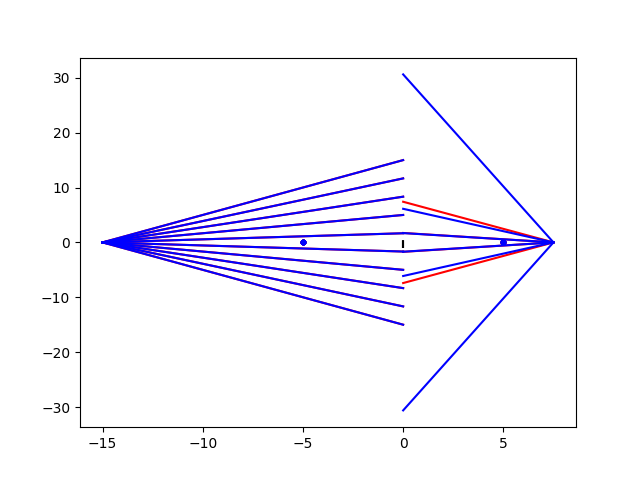

In [99]:
x2, y2, u1, v1, u2, v2, x1_hat, y1_hat, x2_hat, y2_hat = perfect_lens_coords(x1, y1, z1, vx1, vy1, vz1, z2, f, m_p, fourier_lens=1)

plt.figure()
plt.vlines(pp_1, -1, 1, linestyle = '--', color = 'k')
plt.vlines(pp_2,  -1, 1, linestyle = '--', color = 'k')

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)
# plt.plot([z1s + pp_1s, pp_1s], [y1, np.zeros(y1.shape)], '-k')
plt.plot([z1s + pp_1s, pp_1s], [y1, v1], '-r')
# plt.plot([pp_2s, z2s + pp_2s], [np.zeros(y1.shape), y2], '-k')
plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-r')
plt.plot(-fs + pp_1, y1_hat, '.r')
plt.plot(fs + pp_2, y2_hat, '.r')
# plt.axis('equal')

x2, y2, u1, v1, u2, v2, x1_hat, y1_hat, x2_hat, y2_hat = perfect_lens_coords(x1, y1, z1, vx1, vy1, vz1, z2, f, m_p, fourier_lens=0)

# plt.plot([z1s + pp_1s, pp_1s], [y1, np.zeros(y1.shape)], '-k')
plt.plot([z1s + pp_1s, pp_1s], [y1, v1], '-b')
# plt.plot([pp_2s, z2s + pp_2s], [np.zeros(y1.shape), y2], '-k')
plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-b')
plt.plot(-fs + pp_1, y1_hat, '.b')
plt.plot(fs + pp_2, y2_hat, '.b')
# plt.axis('equal')